# <b>1 <span style='color:#4285f4'>|</span> Importing libraries</b>
- **For ML Models**: Tensorflow, keras
- **For Data Manipulation**: numpy, pandas, sklearn
- **For Data Visualization**: matplotlib, seaborn

In [1]:
# For Data Processing
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image, ImageEnhance


# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Miscellaneous
from tqdm import tqdm
import os
import pandas as pd
import random

# <b>2 <span style='color:#4285f4'>|</span> Reading the Dataset</b>

In [2]:
import splitfolders
data_path = r'D:\Machine Learning\ML algo & dataset\dcv ai\lab eval\Brain MRI Images for Brain Tumor Detection'

splitfolders.ratio(data_path, output="output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

In [3]:
train_dir = r'D:\Machine Learning\ML algo & dataset\dcv ai\output\train'
test_dir = r'D:\Machine Learning\ML algo & dataset\dcv ai\output\test'

train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        temp = os.path.join(train_dir, label)
        new_path = os.path.join(temp,image)
        train_paths.append(new_path)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

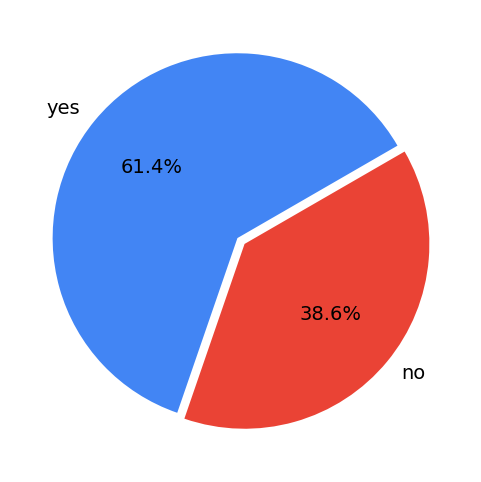

In [4]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len([x for x in train_labels if x=='yes']),
         len([x for x in train_labels if x=='no'])],
        labels=['yes','no'],
        colors=colors, autopct='%.1f%%', explode=(0.025,0.025),
        startangle=30);

#### The dataset is reasonably balanced

In [5]:
test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        temp = os.path.join(test_dir, label)
        new_path = os.path.join(temp,image)
        test_paths.append(new_path)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

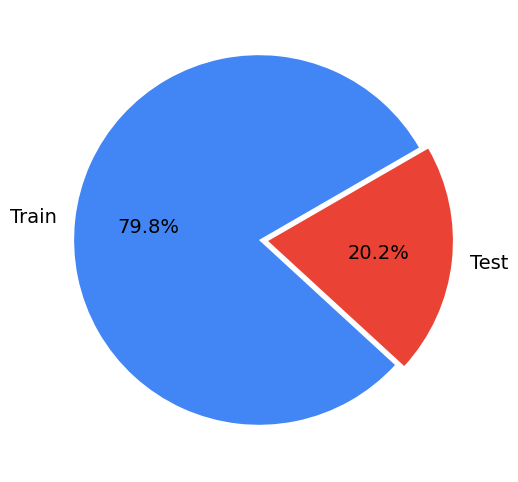

In [6]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

# <b>3 <span style='color:#4285f4'>|</span> Data Augmentation</b>
- Random Brightness: 80% - 120%  
- Random Contrast: 80% - 120%


In [7]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8,1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8,1.2))
    image = np.array(image)/255.0
    return image

<h3 style="font-family:Sans;">Let's plot some Samples :</h3>

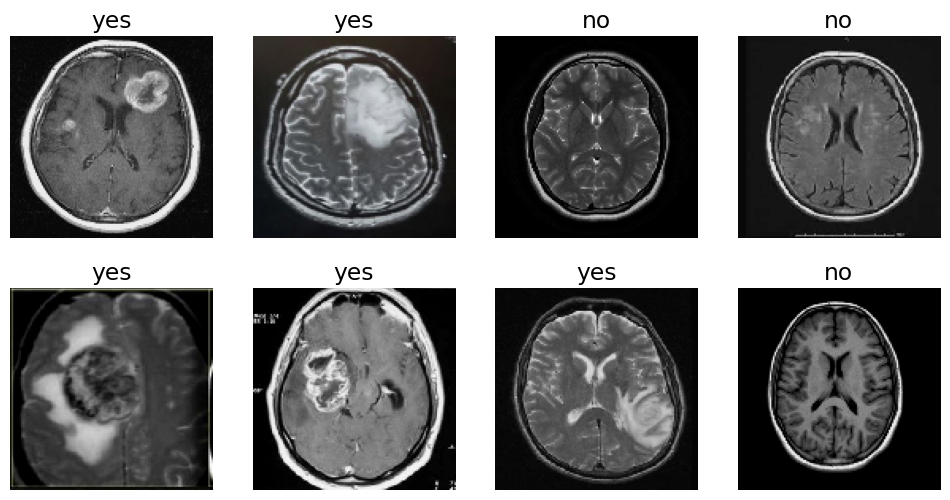

In [8]:
IMAGE_SIZE = 128

def open_images(paths):
    '''
    Given a list of paths to images, this function returns the images as arrays (after augmenting them)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

images = open_images(train_paths[50:59])
labels = train_labels[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.rcParams.update({'font.size': 12})
plt.show()

In [9]:
print(images.shape)

(9, 128, 128, 3)


# <b>4 <span style='color:#4285f4'>|</span> Data Generator</b>
<p style="font-size:15px; font-family:Sans; line-height: 1.7em">
    Given a list of paths to images, and the labels, <br>
    this function augments the images, normalizes them, encodes the label, and then returns the batch on which the model can train on. <br>
</p>

In [10]:
unique_labels = os.listdir(train_dir)

def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

# <b>5 <span style='color:#4285f4'>|</span> Model</b>

### I am using **VGG19** for transfer learning

In [11]:
base_model = VGG19(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(unique_labels), activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 21,073,346
Trainable params: 8,128,386
Non

In [13]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

# <b>6 <span style='color:#4285f4'>|</span> Train Model</b>

In [15]:
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 50
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/50
10/10 [==============================] - 11s 153ms/step - loss: 0.7202 - sparse_categorical_accuracy: 0.6300
Epoch 2/50
10/10 [==============================] - 1s 63ms/step - loss: 0.4561 - sparse_categorical_accuracy: 0.7967
Epoch 3/50
10/10 [==============================] - 1s 57ms/step - loss: 0.5846 - sparse_categorical_accuracy: 0.7033
Epoch 4/50
10/10 [==============================] - 1s 59ms/step - loss: 0.4016 - sparse_categorical_accuracy: 0.8077
Epoch 5/50
10/10 [==============================] - 1s 57ms/step - loss: 0.2366 - sparse_categorical_accuracy: 0.9231
Epoch 6/50
10/10 [==============================] - 1s 59ms/step - loss: 0.1693 - sparse_categorical_accuracy: 0.9231
Epoch 7/50
10/10 [==============================] - 1s 57ms/step - loss: 0.1309 - sparse_categorical_accuracy: 0.9560
Epoch 8/50
10/10 [==============================] - 1s 61ms/step - loss: 0.0654 - sparse_categorical_accuracy: 0.9780
Epoch 9/50
10/10 [==============================] - 1s

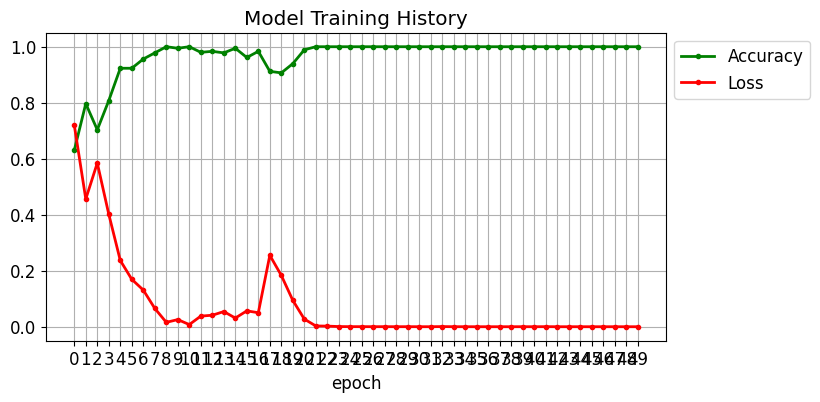

In [16]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# <b>7 <span style='color:#4285f4'>|</span> Evaluate Model with Test Samples</b>

In [17]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


100%|██████████| 1/1 [00:04<00:00,  4.84s/it]

1/1 [==============================] - 2s 2s/step


2it [00:07,  3.64s/it]                       


['no', 'yes'] 

1/1 [==============================] - 1s 525ms/step
[[9.9999976e-01 2.7638973e-07]] 

There is no tumor


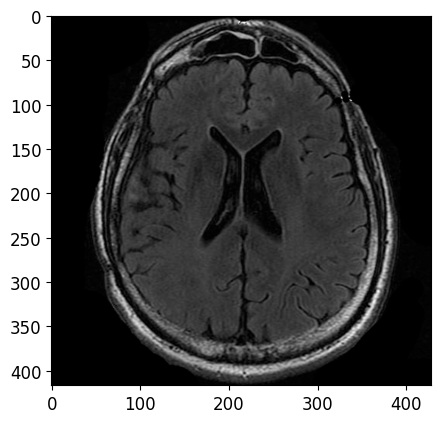

In [18]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path=r'D:\Machine Learning\ML algo & dataset\dcv ai\output\test\no\7 no.jpg'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==0):
    print("There is no tumor")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a tumor")


In [19]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          no       0.94      0.85      0.89        20
         yes       0.91      0.97      0.94        31

    accuracy                           0.92        51
   macro avg       0.93      0.91      0.92        51
weighted avg       0.92      0.92      0.92        51



## Resnet

In [20]:
resnet_model = ResNet152(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), 
                         include_top=False, weights='imagenet')


# Set all layers to non-trainable
for layer in resnet_model.layers:
    layer.trainable = False
# Set the last resnet block to trainable
resnet_model.layers[-2].trainable = True
resnet_model.layers[-3].trainable = True
resnet_model.layers[-4].trainable = True

model_2 = Sequential()
model_2.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model_2.add(resnet_model)
model_2.add(Flatten())
model_2.add(Dropout(0.3))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(Dense(len(unique_labels), activation='softmax'))

In [21]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 4, 4, 2048)        58370944  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dropout_2 (Dropout)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 62,565,634
Trainable params: 5,249,410
N

In [22]:
model_2.compile(optimizer=Adam(learning_rate=0.0001),
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])

In [23]:
early = keras.callbacks.EarlyStopping(monitor="loss",patience= 10)
callbacks_list = [early]


batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 50
history = model_2.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps,callbacks=callbacks_list)

Epoch 1/50
10/10 [==============================] - 10s 74ms/step - loss: 0.7961 - sparse_categorical_accuracy: 0.5900
Epoch 2/50
10/10 [==============================] - 1s 73ms/step - loss: 0.5917 - sparse_categorical_accuracy: 0.7308
Epoch 3/50
10/10 [==============================] - 1s 71ms/step - loss: 0.6100 - sparse_categorical_accuracy: 0.7198
Epoch 4/50
10/10 [==============================] - 1s 71ms/step - loss: 0.4776 - sparse_categorical_accuracy: 0.7747
Epoch 5/50
10/10 [==============================] - 1s 72ms/step - loss: 0.4660 - sparse_categorical_accuracy: 0.8187
Epoch 6/50
10/10 [==============================] - 1s 70ms/step - loss: 0.4350 - sparse_categorical_accuracy: 0.8077
Epoch 7/50
10/10 [==============================] - 1s 70ms/step - loss: 0.3793 - sparse_categorical_accuracy: 0.8516
Epoch 8/50
10/10 [==============================] - 1s 70ms/step - loss: 0.3294 - sparse_categorical_accuracy: 0.8626
Epoch 9/50
10/10 [==============================] - 1s 

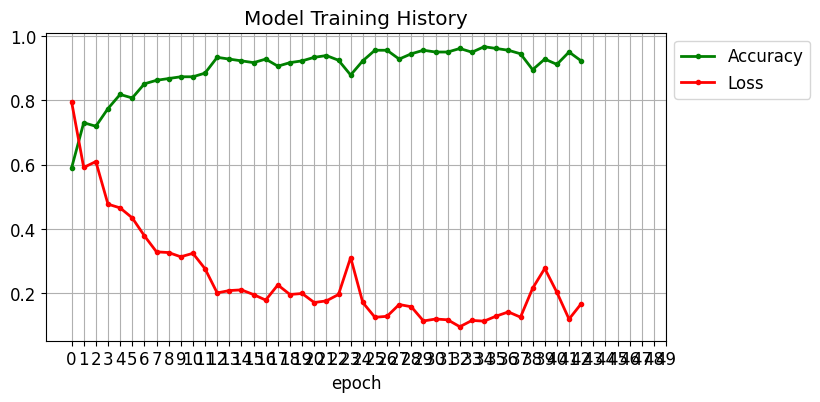

In [24]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [25]:
batch_size = 32
steps = int(len(test_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
    pred = model_2.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]

1/1 [==============================] - 3s 3s/step


2it [00:05,  2.93s/it]                       


In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
path=r'D:\Machine Learning\ML algo & dataset\dcv ai\output\test\no\7 no.jpg'

my_image = load_img(path, target_size=(128, 128))

#preprocess the image
my_image = img_to_array(my_image)
my_image = my_image/255
my_image = my_image.reshape((1, my_image.shape[0], my_image.shape[1], my_image.shape[2]))
#my_image = preprocess_input(my_image)
print(unique_labels,'\n')
#make the prediction
prediction = model_2.predict(my_image)
print(prediction,'\n')
predict_index = np.argmax(prediction)
if(predict_index==0):
    print("There is no tumor")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()
else:
    print("There is a tumor")


['no', 'yes'] 

1/1 [==============================] - 0s 127ms/step
[[0.3877476 0.6122524]] 

There is a tumor


In [27]:
from sklearn.metrics import accuracy_score

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          no       0.81      0.65      0.72        20
         yes       0.80      0.90      0.85        31

    accuracy                           0.80        51
   macro avg       0.81      0.78      0.79        51
weighted avg       0.80      0.80      0.80        51



Epoch 1/50
10/10 [==============================] - 8s 76ms/step - loss: 1.1764 - sparse_categorical_accuracy: 0.7100
Epoch 2/50
10/10 [==============================] - 1s 75ms/step - loss: 0.2423 - sparse_categorical_accuracy: 0.9231
Epoch 3/50
10/10 [==============================] - 1s 68ms/step - loss: 0.2484 - sparse_categorical_accuracy: 0.9176
Epoch 4/50
10/10 [==============================] - 1s 69ms/step - loss: 0.2440 - sparse_categorical_accuracy: 0.9176
Epoch 5/50
10/10 [==============================] - 1s 69ms/step - loss: 0.1637 - sparse_categorical_accuracy: 0.9286
Epoch 6/50
10/10 [==============================] - 1s 71ms/step - loss: 0.1737 - sparse_categorical_accuracy: 0.9176
Epoch 7/50
10/10 [==============================] - 1s 70ms/step - loss: 0.1053 - sparse_categorical_accuracy: 0.9670
Epoch 8/50
10/10 [==============================] - 1s 70ms/step - loss: 0.0962 - sparse_categorical_accuracy: 0.9560
Epoch 9/50
10/10 [==============================] - 1s 7

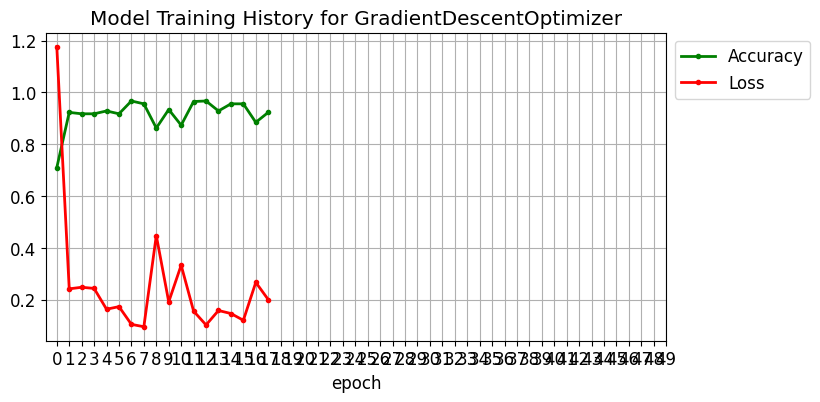

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

1/1 [==============================] - 2s 2s/step


2it [00:05,  2.88s/it]                       

Epoch 1/50


10/10 [==============================] - 8s 74ms/step - loss: 0.0995 - sparse_categorical_accuracy: 0.9650
Epoch 2/50
10/10 [==============================] - 1s 74ms/step - loss: 0.1281 - sparse_categorical_accuracy: 0.9505
Epoch 3/50
10/10 [==============================] - 1s 70ms/step - loss: 0.1527 - sparse_categorical_accuracy: 0.9286
Epoch 4/50
10/10 [==============================] - 1s 69ms/step - loss: 0.1017 - sparse_categorical_accuracy: 0.9505
Epoch 5/50
10/10 [==============================] - 1s 70ms/step - loss: 0.1692 - sparse_categorical_accuracy: 0.9176
Epoch 6/50
10/10 [==============================] - 1s 69ms/step - loss: 0.1023 - sparse_categorical_accuracy: 0.9670
Epoch 7/50
10/10 [==============================] - 1s 69ms/step - loss: 0.1207 - sparse_categorical_accuracy: 0.9341
Epoch 8/50
10/10 [==============================] - 1s 69ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9670
Epoch 9/50
10/10 [==============================] - 1s 70ms/step - 

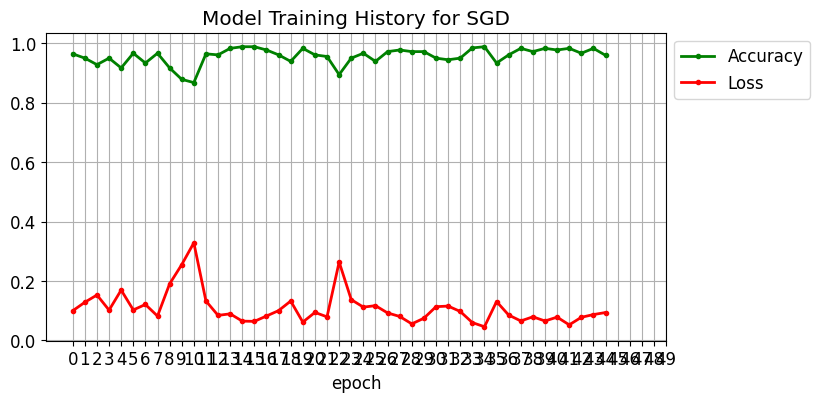

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]

1/1 [==============================] - 2s 2s/step


2it [00:05,  2.87s/it]                       

Epoch 1/50


10/10 [==============================] - 8s 75ms/step - loss: 1.7104 - sparse_categorical_accuracy: 0.6550
Epoch 2/50
10/10 [==============================] - 1s 73ms/step - loss: 0.5617 - sparse_categorical_accuracy: 0.6923
Epoch 3/50
10/10 [==============================] - 1s 69ms/step - loss: 0.3975 - sparse_categorical_accuracy: 0.8077
Epoch 4/50
10/10 [==============================] - 1s 69ms/step - loss: 0.5905 - sparse_categorical_accuracy: 0.7418
Epoch 5/50
10/10 [==============================] - 1s 69ms/step - loss: 0.3052 - sparse_categorical_accuracy: 0.8736
Epoch 6/50
10/10 [==============================] - 1s 69ms/step - loss: 0.3735 - sparse_categorical_accuracy: 0.8791
Epoch 7/50
10/10 [==============================] - 1s 69ms/step - loss: 0.3978 - sparse_categorical_accuracy: 0.8516
Epoch 8/50
10/10 [==============================] - 1s 73ms/step - loss: 0.2041 - sparse_categorical_accuracy: 0.9066
Epoch 9/50
10/10 [==============================] - 1s 71ms/step - 

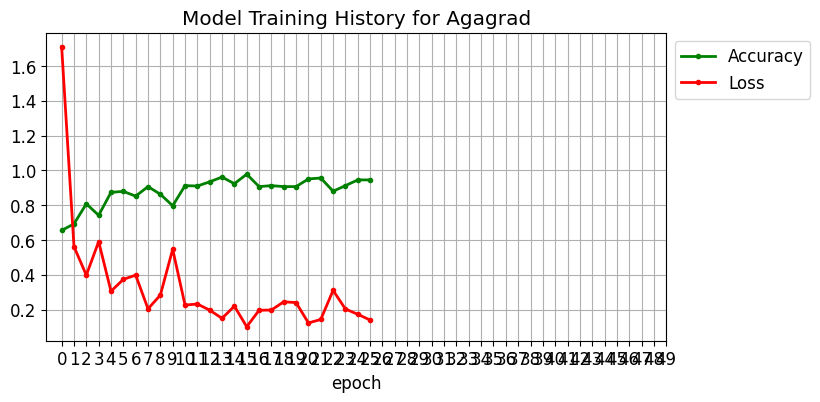

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]

1/1 [==============================] - 2s 2s/step


2it [00:05,  2.66s/it]                       

Epoch 1/50


10/10 [==============================] - 9s 74ms/step - loss: 0.1287 - sparse_categorical_accuracy: 0.9650
Epoch 2/50
10/10 [==============================] - 1s 77ms/step - loss: 0.1048 - sparse_categorical_accuracy: 0.9615
Epoch 3/50
10/10 [==============================] - 1s 75ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9670
Epoch 4/50
10/10 [==============================] - 1s 71ms/step - loss: 0.1042 - sparse_categorical_accuracy: 0.9505
Epoch 5/50
10/10 [==============================] - 1s 71ms/step - loss: 0.0943 - sparse_categorical_accuracy: 0.9670
Epoch 6/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0949 - sparse_categorical_accuracy: 0.9560
Epoch 7/50
10/10 [==============================] - 1s 72ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9670
Epoch 8/50
10/10 [==============================] - 1s 73ms/step - loss: 0.1229 - sparse_categorical_accuracy: 0.9560
Epoch 9/50
10/10 [==============================] - 1s 70ms/step - 

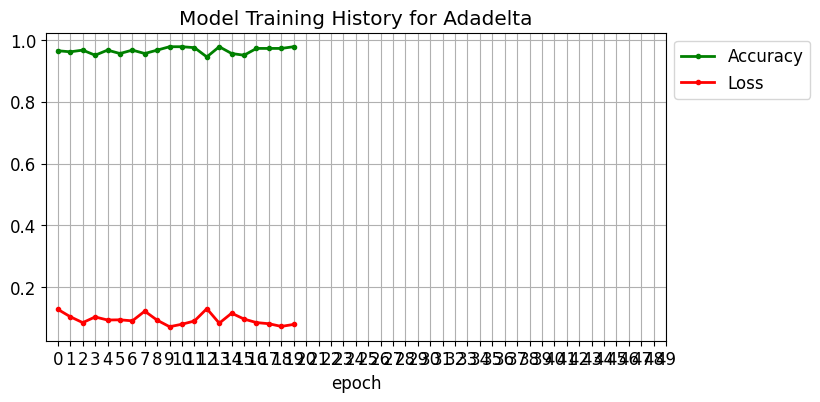

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]

1/1 [==============================] - 2s 2s/step


2it [00:05,  2.95s/it]                       

Epoch 1/50


10/10 [==============================] - 9s 80ms/step - loss: 4.6478 - sparse_categorical_accuracy: 0.6400
Epoch 2/50
10/10 [==============================] - 1s 75ms/step - loss: 1.2407 - sparse_categorical_accuracy: 0.5330
Epoch 3/50
10/10 [==============================] - 1s 68ms/step - loss: 1.3855 - sparse_categorical_accuracy: 0.6374
Epoch 4/50
10/10 [==============================] - 1s 71ms/step - loss: 0.6451 - sparse_categorical_accuracy: 0.6648
Epoch 5/50
10/10 [==============================] - 1s 70ms/step - loss: 0.6201 - sparse_categorical_accuracy: 0.7198
Epoch 6/50
10/10 [==============================] - 1s 73ms/step - loss: 0.6299 - sparse_categorical_accuracy: 0.7033
Epoch 7/50
10/10 [==============================] - 1s 68ms/step - loss: 0.5502 - sparse_categorical_accuracy: 0.7747
Epoch 8/50
10/10 [==============================] - 1s 68ms/step - loss: 0.5044 - sparse_categorical_accuracy: 0.7857
Epoch 9/50
10/10 [==============================] - 1s 73ms/step - 

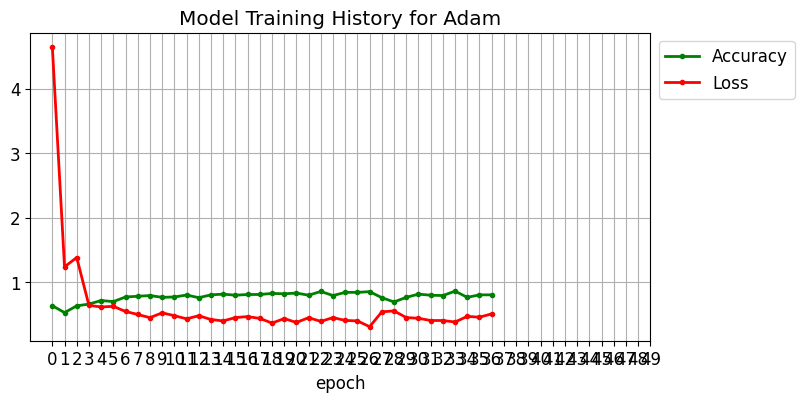

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

1/1 [==============================] - 3s 3s/step


2it [00:06,  3.48s/it]                       


In [28]:
from tensorflow.compat.v1.train import GradientDescentOptimizer

optimizers_list = [GradientDescentOptimizer(learning_rate=0.01),
                   SGD(learning_rate=0.01),
                   Adagrad(learning_rate= 0.01),
                   Adadelta(learning_rate=0.01),
                   Adam(learning_rate=0.01)]

dict = {'GradientDescentOptimizer': 0,'SGD':0,'Agagrad':0,'Adadelta':0,'Adam':0}

cnt = 0
for i in optimizers_list:
    model_2.compile(optimizer = i,
             loss='sparse_categorical_crossentropy',
             metrics=['sparse_categorical_accuracy'])
    
    early = keras.callbacks.EarlyStopping(monitor="loss",patience= 10)
    callbacks_list = [early]


    batch_size = 20
    steps = int(len(train_paths)/batch_size)
    epochs = 50
    history = model_2.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                        epochs=epochs, steps_per_epoch=steps,callbacks=callbacks_list)
    
    plt.figure(figsize=(8,4))
    plt.grid(True)
    plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
    plt.plot(history.history['loss'], '.r-', linewidth=2)
    title_name = 'Model Training History for ' + str(list(dict.keys())[cnt])
    plt.title(title_name)
    plt.xlabel('epoch')
    plt.xticks([x for x in range(epochs)])
    plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()
    
    batch_size = 32
    steps = int(len(test_paths)/batch_size)
    y_pred = []
    y_true = []
    for x,y in tqdm(datagen(test_paths, test_labels, batch_size=batch_size, epochs=1), total=steps):
        pred = model_2.predict(x)
        pred = np.argmax(pred, axis=-1)
        for i in decode_label(pred):
            y_pred.append(i)
        for i in decode_label(y):
            y_true.append(i)
    
    dict[list(dict.keys())[cnt]]= accuracy_score(y_true,y_pred)
    cnt= cnt+1

In [29]:
print(dict)

{'GradientDescentOptimizer': 0.7450980392156863, 'SGD': 0.7843137254901961, 'Agagrad': 0.6666666666666666, 'Adadelta': 0.7450980392156863, 'Adam': 0.6470588235294118}
